In [1]:
import sys
import gc
import os
import re
import time
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from sklearn.metrics import accuracy_score

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common. by import By
from bs4 import BeautifulSoup 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import konlpy
import pykospacing
import soynlp
from konlpy.tag import Kkma, Hannanum, Komoran, Mecab, Twitter
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import kss
from konlpy.tag import Okt

# Scrapping

In [22]:
gc.collect()
# make sure all garbage cleared before collecting referrers.

585

In [23]:
chrome_options = webdriver.ChromeOptions()

chrome_driver = 'C:/Users/user/파이썬/텍데분/과제/chromedriver.exe'
driver = webdriver.Chrome('C:/Users/user/파이썬/텍데분/과제/chromedriver.exe')

In [24]:
driver.get("https://www.musinsa.com/goods/reviews/lists?type=style&searchYear=2023&searchMonth=&searchDay=&maxRt=2023&minRt=2009&brand=&page=1&sort=new&hashId=&bestType=&s_type=all&searchKeyword=")

In [25]:
gc.collect()

53

In [26]:
user_list = []
item_list = []
rating_list = []
review_list = []

In [39]:
for i in tqdm_notebook(range(201, 300)): 
    gc.collect()
    driver = webdriver.Chrome(chrome_driver)
    time.sleep(1)
    # 일단 월별 추천순으로
    driver.get("https://www.musinsa.com/goods/reviews/lists?type=style&searchYear=2023&searchMonth=&searchDay=&maxRt=2023&minRt=2009&brand=&page={}&sort=new&hashId=&bestType=&s_type=all&searchKeyword=".format(i))
    time.sleep(1)
    for j in range(0, 20):
        # 유저 레벨이 너무 낮으면 신뢰도가 떨어질 것이라 판단해 유저 레벨 3이상인 경우의 리뷰만
        if int((driver.find_elements_by_css_selector('div.review-list > div.review-profile > div.review-profile__text-wrap > div.review-profile__text > p.review-profile__name')[j].text)[3]) >= 3:
            # 해당 유저명 변수 저장
            user_name = driver.find_elements_by_css_selector('div.review-list > div.review-profile > div.review-profile__text-wrap > div.review-profile__text > p.review-profile__name')[j].text
            # 해당 유저 이미지 클릭 -> 해당 유저가 남긴 모든 리뷰 확인 가능
            driver.find_elements_by_css_selector('div.review-list > div.review-profile > a')[j].click()
            time.sleep(1)
            # 해당 유저의 프로필에 들어가 페이지가 여러개면 그만큼 누르게 만들어 넘어가 리뷰를 긁어오기
            for m in range(len(driver.find_elements_by_css_selector('div.nslist_bottom > div.pagination.textRight > div.wrapper > a'))-2):
                # 해당 유저의 모든 리뷰 수집
                for k in range(len(driver.find_elements_by_css_selector('div.review-list-wrap.review-list-wrap--member-review > div.review-list'))):
                    #상품명
                    item_name = driver.find_elements_by_css_selector('div.review-list > div.review-goods-information > div.review-goods-information__item')[k].text.split('\n')[1]
                    #별점
                    rating = driver.find_elements_by_css_selector('div.review-list > div.review-list__rating-wrap > span.review-list__rating > span.review-list__rating__unit > span.review-list__rating__active')[k]
                    #리뷰 text
                    review = driver.find_elements_by_css_selector('div.review-list > div.review-contents > div.review-contents__text')[k].text
                    # rating 조건 별하나당 width 가 18개임
                    if rating.size['width'] == 90:
                        rating = 5
                    elif rating.size['width'] == 72:
                        rating = 4
                    elif rating.size['width'] == 54:
                        rating = 3
                    elif rating.size['width'] == 36:
                        rating = 2
                    elif rating.size['width'] == 18:
                        rating = 1       

                    user_list.append(user_name)
                    item_list.append(item_name)
                    rating_list.append(rating)
                    review_list.append(review)
                # 해당 유저의 프로필에 들어가 페이지 다 넘어가면 다시 원래 전체 리뷰있는 페이지로 이동        
                if m == len(driver.find_elements_by_css_selector('div.nslist_bottom > div.pagination.textRight > div.wrapper > a')) -3:
                    time.sleep(1)
                    driver.get("https://www.musinsa.com/goods/reviews/lists?type=style&searchYear=2023&searchMonth=&searchDay=&maxRt=2023&minRt=2009&brand=&page={}&sort=new&hashId=&bestType=&s_type=all&searchKeyword=".format(i))
                    time.sleep(1)
                else:
                    pass
        else:
            pass

  0%|          | 0/99 [00:00<?, ?it/s]

In [40]:
df = pd.DataFrame({'유저명' : user_list, '아이템명': item_list, '평점' : rating_list, '리뷰' : review_list})

In [42]:
df = df.drop_duplicates()

In [45]:
df.to_csv("201~300.csv")

___

# 데이터 불러오기

In [4]:
df1 = pd.read_csv('1~100.csv')
df2 = pd.read_csv('110~126.csv')
df3 = pd.read_csv('127~200.csv')
df4 = pd.read_csv('201~300.csv')

df = pd.concat([df1,df2,df3,df4], axis=0)
df = df.drop(columns = 'Unnamed: 0', axis =1 )
df = df.drop_duplicates()

In [81]:
import copy

with open('stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = f.readlines()
stopwords = [x.replace('\n','') for x in stopwords] # stopword 파일의 줄바꿈 문자 제거
okt = Okt()

def preprocess_korean(text):
    my_text = copy.copy(text)
    my_text = my_text.replace('\n', '')
    spacer = pykospacing.Spacing()
    my_text = spacer(my_text) # (3) 띄어쓰기 교정
    sents = kss.split_sentences(my_text)# (4) sentence tokenization
    
    p = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]')
    results = []
    for sent in sents:
        result = []
        tokens = okt.morphs(sent, stem=True) # (6) word tokenization
        for token in tokens:
            token = p.sub('', token) # (5) 특수문자 제거
            if token not in stopwords:
                result.append(token) # (7) stopword removal
        results.extend(result)
    result = ' '.join(results)
    
    return result

In [82]:
df['전처리_리뷰'] = df['리뷰'].apply(lambda x: preprocess_korean(x))

In [83]:
df.to_csv("전처리끈나땅~~.csv")

___

___

___

# WordCloud

In [3]:
df = pd.read_csv('전처리끈나땅~~.csv')

In [101]:
df['평점'].value_counts()

5    10047
4     1004
3      178
2       21
1       15
Name: 평점, dtype: int64

In [85]:
df_g = df[df['평점'] > 3]
df_b = df[df['평점'] < 3]

In [86]:
# wordcloud에서 한글을 사용할 수 있도록 설정하기
font_path = 'C:\\Users\\user\\anaconda3\\envs\\text\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\malgun.ttf'

In [87]:
my_str_bad = ' '.join([x for x in df_b['preprocessed_리뷰']])

In [88]:
cloud = WordCloud(font_path = font_path, 
                  background_color = 'white', 
                  width=800, height=800)

In [ ]:
# 하다, 입다, 도

In [89]:
my_cloud1 = cloud.generate_from_text(my_str_bad)

In [90]:
arr1 = my_cloud1.to_array()
print(type(arr1))
print(arr1.shape)

<class 'numpy.ndarray'>
(800, 800, 3)


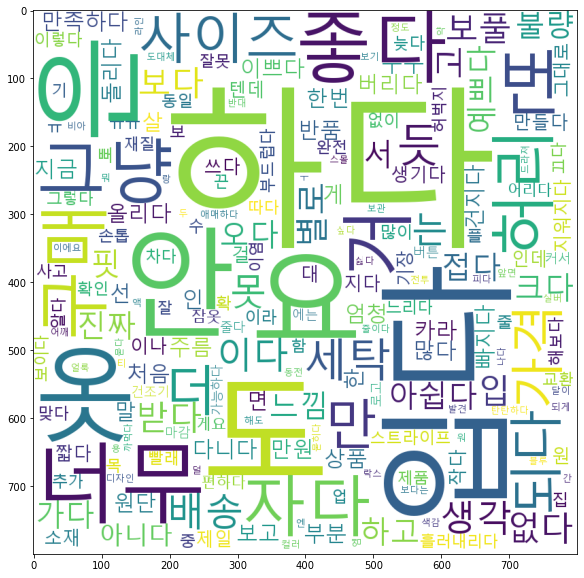

In [91]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(arr1)
plt.show()
# fig.savefig('wordcloud_without_axisoff.png') 생성한 그림 저장하기

In [92]:
my_str_good = ' '.join([x for x in df_g['preprocessed_리뷰']])

In [93]:
my_cloud2 = cloud.generate_from_text(my_str_good)

In [94]:
arr2 = my_cloud2.to_array()
print(type(arr2))
print(arr2.shape)

<class 'numpy.ndarray'>
(800, 800, 3)


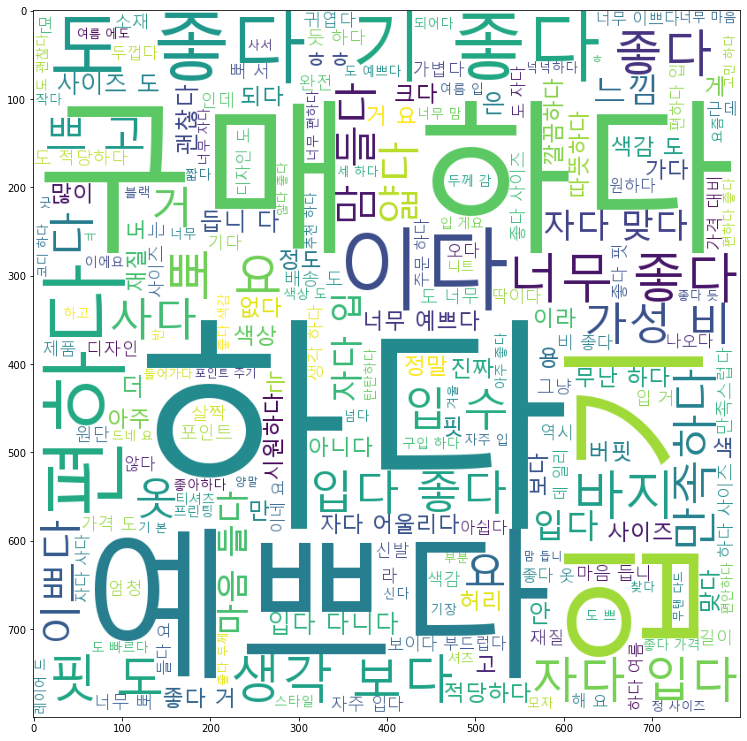

In [95]:
fig = plt.figure(figsize=(13, 13))
plt.imshow(arr2)
plt.show()
# fig.savefig('wordcloud_without_axisoff.png') 생성한 그림 저장하기

# Text_calssification

In [9]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

In [6]:
import copy

with open('stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = f.readlines()
stopwords = [x.replace('\n','') for x in stopwords] # stopword 파일의 줄바꿈 문자 제거

In [8]:
tfidf = TfidfVectorizer(stop_words = stopwords)
tfidf_mat = tfidf.fit_transform(df['preprocessed_리뷰'])

In [10]:
X = tfidf_mat.toarray()
y = df['평점'].to_numpy()

In [13]:
x_trn, x_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, stratify=y)

In [14]:
model = CatBoostClassifier(random_state = 0)
model.fit(x_trn, y_trn)

Learning rate set to 0.088515
0:	learn: 1.3581616	total: 350ms	remaining: 5m 49s
1:	learn: 1.1884437	total: 494ms	remaining: 4m 6s
2:	learn: 1.0634449	total: 648ms	remaining: 3m 35s
3:	learn: 0.9661679	total: 799ms	remaining: 3m 18s
4:	learn: 0.8876691	total: 953ms	remaining: 3m 9s
5:	learn: 0.8231430	total: 1.11s	remaining: 3m 3s
6:	learn: 0.7693657	total: 1.27s	remaining: 3m
7:	learn: 0.7237034	total: 1.42s	remaining: 2m 55s
8:	learn: 0.6847642	total: 1.57s	remaining: 2m 52s
9:	learn: 0.6511099	total: 1.71s	remaining: 2m 49s
10:	learn: 0.6218519	total: 1.87s	remaining: 2m 47s
11:	learn: 0.5965151	total: 2.02s	remaining: 2m 45s
12:	learn: 0.5742582	total: 2.17s	remaining: 2m 44s
13:	learn: 0.5547454	total: 2.31s	remaining: 2m 42s
14:	learn: 0.5375601	total: 2.47s	remaining: 2m 42s
15:	learn: 0.5216980	total: 2.63s	remaining: 2m 41s
16:	learn: 0.5080676	total: 2.78s	remaining: 2m 40s
17:	learn: 0.4952855	total: 2.92s	remaining: 2m 39s
18:	learn: 0.4847319	total: 3.07s	remaining: 2m 38s

157:	learn: 0.3580683	total: 24s	remaining: 2m 7s
158:	learn: 0.3579186	total: 24.1s	remaining: 2m 7s
159:	learn: 0.3578332	total: 24.3s	remaining: 2m 7s
160:	learn: 0.3576558	total: 24.4s	remaining: 2m 7s
161:	learn: 0.3573657	total: 24.6s	remaining: 2m 7s
162:	learn: 0.3572284	total: 24.7s	remaining: 2m 6s
163:	learn: 0.3571505	total: 24.9s	remaining: 2m 6s
164:	learn: 0.3569744	total: 25s	remaining: 2m 6s
165:	learn: 0.3568836	total: 25.2s	remaining: 2m 6s
166:	learn: 0.3567304	total: 25.3s	remaining: 2m 6s
167:	learn: 0.3566514	total: 25.5s	remaining: 2m 6s
168:	learn: 0.3565864	total: 25.6s	remaining: 2m 5s
169:	learn: 0.3561316	total: 25.8s	remaining: 2m 5s
170:	learn: 0.3560235	total: 25.9s	remaining: 2m 5s
171:	learn: 0.3559309	total: 26s	remaining: 2m 5s
172:	learn: 0.3557550	total: 26.2s	remaining: 2m 5s
173:	learn: 0.3556465	total: 26.3s	remaining: 2m 5s
174:	learn: 0.3555759	total: 26.5s	remaining: 2m 4s
175:	learn: 0.3553908	total: 26.6s	remaining: 2m 4s
176:	learn: 0.3552

315:	learn: 0.3383382	total: 47.8s	remaining: 1m 43s
316:	learn: 0.3382691	total: 48s	remaining: 1m 43s
317:	learn: 0.3381801	total: 48.1s	remaining: 1m 43s
318:	learn: 0.3378718	total: 48.3s	remaining: 1m 43s
319:	learn: 0.3378191	total: 48.4s	remaining: 1m 42s
320:	learn: 0.3377485	total: 48.6s	remaining: 1m 42s
321:	learn: 0.3376852	total: 48.7s	remaining: 1m 42s
322:	learn: 0.3375764	total: 48.9s	remaining: 1m 42s
323:	learn: 0.3375280	total: 49s	remaining: 1m 42s
324:	learn: 0.3374438	total: 49.2s	remaining: 1m 42s
325:	learn: 0.3373981	total: 49.3s	remaining: 1m 41s
326:	learn: 0.3373362	total: 49.5s	remaining: 1m 41s
327:	learn: 0.3372330	total: 49.6s	remaining: 1m 41s
328:	learn: 0.3371547	total: 49.7s	remaining: 1m 41s
329:	learn: 0.3370781	total: 49.9s	remaining: 1m 41s
330:	learn: 0.3369707	total: 50s	remaining: 1m 41s
331:	learn: 0.3368592	total: 50.2s	remaining: 1m 40s
332:	learn: 0.3365395	total: 50.3s	remaining: 1m 40s
333:	learn: 0.3364645	total: 50.5s	remaining: 1m 40s

471:	learn: 0.3249895	total: 1m 11s	remaining: 1m 19s
472:	learn: 0.3249022	total: 1m 11s	remaining: 1m 19s
473:	learn: 0.3248303	total: 1m 11s	remaining: 1m 19s
474:	learn: 0.3247280	total: 1m 11s	remaining: 1m 19s
475:	learn: 0.3246775	total: 1m 11s	remaining: 1m 19s
476:	learn: 0.3246346	total: 1m 11s	remaining: 1m 18s
477:	learn: 0.3245280	total: 1m 12s	remaining: 1m 18s
478:	learn: 0.3244830	total: 1m 12s	remaining: 1m 18s
479:	learn: 0.3244237	total: 1m 12s	remaining: 1m 18s
480:	learn: 0.3243540	total: 1m 12s	remaining: 1m 18s
481:	learn: 0.3242835	total: 1m 12s	remaining: 1m 18s
482:	learn: 0.3242555	total: 1m 12s	remaining: 1m 17s
483:	learn: 0.3242165	total: 1m 13s	remaining: 1m 17s
484:	learn: 0.3241614	total: 1m 13s	remaining: 1m 17s
485:	learn: 0.3240989	total: 1m 13s	remaining: 1m 17s
486:	learn: 0.3240080	total: 1m 13s	remaining: 1m 17s
487:	learn: 0.3239679	total: 1m 13s	remaining: 1m 17s
488:	learn: 0.3238842	total: 1m 13s	remaining: 1m 17s
489:	learn: 0.3238016	total:

625:	learn: 0.3149883	total: 1m 34s	remaining: 56.2s
626:	learn: 0.3149401	total: 1m 34s	remaining: 56s
627:	learn: 0.3148977	total: 1m 34s	remaining: 55.9s
628:	learn: 0.3148609	total: 1m 34s	remaining: 55.7s
629:	learn: 0.3148200	total: 1m 34s	remaining: 55.6s
630:	learn: 0.3147865	total: 1m 34s	remaining: 55.4s
631:	learn: 0.3147118	total: 1m 34s	remaining: 55.3s
632:	learn: 0.3146755	total: 1m 35s	remaining: 55.1s
633:	learn: 0.3146340	total: 1m 35s	remaining: 55s
634:	learn: 0.3145964	total: 1m 35s	remaining: 54.8s
635:	learn: 0.3145678	total: 1m 35s	remaining: 54.7s
636:	learn: 0.3145258	total: 1m 35s	remaining: 54.6s
637:	learn: 0.3144819	total: 1m 35s	remaining: 54.4s
638:	learn: 0.3144389	total: 1m 36s	remaining: 54.3s
639:	learn: 0.3143833	total: 1m 36s	remaining: 54.1s
640:	learn: 0.3143360	total: 1m 36s	remaining: 54s
641:	learn: 0.3142064	total: 1m 36s	remaining: 53.8s
642:	learn: 0.3141324	total: 1m 36s	remaining: 53.7s
643:	learn: 0.3140771	total: 1m 36s	remaining: 53.5s

781:	learn: 0.3063052	total: 1m 57s	remaining: 32.8s
782:	learn: 0.3062731	total: 1m 57s	remaining: 32.7s
783:	learn: 0.3062064	total: 1m 58s	remaining: 32.5s
784:	learn: 0.3061703	total: 1m 58s	remaining: 32.4s
785:	learn: 0.3061237	total: 1m 58s	remaining: 32.2s
786:	learn: 0.3059800	total: 1m 58s	remaining: 32.1s
787:	learn: 0.3059492	total: 1m 58s	remaining: 31.9s
788:	learn: 0.3059077	total: 1m 58s	remaining: 31.8s
789:	learn: 0.3058528	total: 1m 58s	remaining: 31.6s
790:	learn: 0.3058118	total: 1m 59s	remaining: 31.5s
791:	learn: 0.3057753	total: 1m 59s	remaining: 31.3s
792:	learn: 0.3057348	total: 1m 59s	remaining: 31.2s
793:	learn: 0.3056981	total: 1m 59s	remaining: 31s
794:	learn: 0.3056368	total: 1m 59s	remaining: 30.9s
795:	learn: 0.3056085	total: 1m 59s	remaining: 30.7s
796:	learn: 0.3055686	total: 2m	remaining: 30.6s
797:	learn: 0.3055221	total: 2m	remaining: 30.4s
798:	learn: 0.3054755	total: 2m	remaining: 30.3s
799:	learn: 0.3054346	total: 2m	remaining: 30.1s
800:	learn:

939:	learn: 0.2975670	total: 2m 21s	remaining: 9.03s
940:	learn: 0.2975382	total: 2m 21s	remaining: 8.88s
941:	learn: 0.2974827	total: 2m 21s	remaining: 8.73s
942:	learn: 0.2974517	total: 2m 21s	remaining: 8.58s
943:	learn: 0.2974053	total: 2m 22s	remaining: 8.43s
944:	learn: 0.2973728	total: 2m 22s	remaining: 8.28s
945:	learn: 0.2973259	total: 2m 22s	remaining: 8.13s
946:	learn: 0.2972986	total: 2m 22s	remaining: 7.98s
947:	learn: 0.2972648	total: 2m 22s	remaining: 7.83s
948:	learn: 0.2972117	total: 2m 22s	remaining: 7.68s
949:	learn: 0.2971625	total: 2m 23s	remaining: 7.53s
950:	learn: 0.2971165	total: 2m 23s	remaining: 7.38s
951:	learn: 0.2970748	total: 2m 23s	remaining: 7.23s
952:	learn: 0.2970392	total: 2m 23s	remaining: 7.08s
953:	learn: 0.2970148	total: 2m 23s	remaining: 6.93s
954:	learn: 0.2969622	total: 2m 23s	remaining: 6.78s
955:	learn: 0.2969107	total: 2m 24s	remaining: 6.63s
956:	learn: 0.2968565	total: 2m 24s	remaining: 6.48s
957:	learn: 0.2968027	total: 2m 24s	remaining:

In [15]:
y_pred = model.predict(x_tst)

In [16]:
pd.DataFrame(y_pred).value_counts()

5    2244
4       7
3       2
dtype: int64

In [17]:
accuracy_score(y_tst, y_pred)

0.893919218819352